In [2]:
import monai
import shutil
from monai.transforms import (
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    Spacingd,
    RandWeightedCrop,
    RandRotate,
    RandFlip,
    Rand3DElasticd,
    Rand3DElastic,
    RandRotated,
    LoadImage,
    EnsureChannelFirstd,
    Orientationd,
    EnsureChannelFirst,
    ScaleIntensityd,
    RandFlip,
    ToTensor,
    SpatialPadd,
    ToTensord,
    ScaleIntensity,
    RandFlipd)
import nibabel
import shutil
import tqdm
from torchmetrics import MeanSquaredError
import time
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, Dataset ,nifti_saver, PatchDataset, PersistentDataset, SmartCacheDataset, ThreadDataLoader
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import nibabel
from glob import glob
from monai.networks.blocks import Convolution
from monai.networks.nets import Discriminator, Generator
from monai.utils import progress_bar
import torch.nn as nn
import torchmetrics 
from pytorchtools import EarlyStopping
import numpy 
import torchvision.transforms as transforms
import random
from functools import reduce
from operator import mul
from torch.utils.data import DataLoader

from torchmetrics import StructuralSimilarityIndexMeasure as SSIM

In [3]:
date="July19"#  put current date if training, test if just testing

if not os.path.exists(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}'):
    os.makedirs(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}')
    
if date != "test":
    shutil.copy('/home/fogunsan/scratch/degad/repo/MRI-DeGad/src/9a-train_degad_CNN_c3d_16.py', f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/')

In [4]:
fname_tr='/localscratch/tmp/training_samples_15.dat'
                        # Patch dimensions

patch_radius= numpy.array([7,7,7])
dims = 1+2*patch_radius 
dims = dims.astype('int')

k = 2                                 # Number of channels
bps = (4 * k * numpy.prod(dims))    # Bytes per sample
np_tr = os.path.getsize(fname_tr) // bps      # Number of samples

arr_shape_tr= (int(np_tr),dims[0],dims[1],dims[2], k)

arr_train = numpy.memmap(fname_tr,'float32','r+',shape=arr_shape_tr)
#arr_train = numpy.swapaxes(arr_train,1,4)
"""
fig, axes = plt.subplots(8, 2,figsize=(5,15))
plt.suptitle('Whole brain slices: Gad, NonGad, Degad')

for i in range (1,17,2):    
    x = random.randint(1,14)
    y = random.randint(1,2000)
    z = random.randint(40, 190)
    plt.subplot(8, 2, i)
    plt.imshow(numpy.squeeze(arr_train[y,x, :,:,0]) ,cmap="gray")
    plt.subplot(8,2 ,i+1)
    plt.imshow(numpy.squeeze(arr_train[y,x, :,:,1]) ,cmap="gray")

"""

'\nfig, axes = plt.subplots(8, 2,figsize=(5,15))\nplt.suptitle(\'Whole brain slices: Gad, NonGad, Degad\')\n\nfor i in range (1,17,2):    \n    x = random.randint(1,14)\n    y = random.randint(1,2000)\n    z = random.randint(40, 190)\n    plt.subplot(8, 2, i)\n    plt.imshow(numpy.squeeze(arr_train[y,x, :,:,0]) ,cmap="gray")\n    plt.subplot(8,2 ,i+1)\n    plt.imshow(numpy.squeeze(arr_train[y,x, :,:,1]) ,cmap="gray")\n\n'

In [6]:
fname_va='/localscratch/tmp/validation_samples_15.dat'
                        # Patch dimensions

np_va = os.path.getsize(fname_va) // bps      # Number of samples

arr_shape_va= (int(np_va),dims[0],dims[1],dims[2], k)

arr_val= numpy.memmap(fname_va,'float32','r+',shape=arr_shape_va)
#arr_train = numpy.swapaxes(arr_train,1,4)
"""
fig, axes = plt.subplots(8, 2,figsize=(5,15))
plt.suptitle('Whole brain slices: Gad, NonGad, Degad')

for i in range (1,17,2):    
    x = random.randint(1,14)
    y = random.randint(1,2000)
    z = random.randint(40, 190)
    plt.subplot(8, 2, i)
    plt.imshow(numpy.squeeze(arr_val[y,x, :,:,0]) ,cmap="gray")
    plt.subplot(8,2 ,i+1)
    plt.imshow(numpy.squeeze(arr_val[y,x, :,:,1]) ,cmap="gray")
"""

'\nfig, axes = plt.subplots(8, 2,figsize=(5,15))\nplt.suptitle(\'Whole brain slices: Gad, NonGad, Degad\')\n\nfor i in range (1,17,2):    \n    x = random.randint(1,14)\n    y = random.randint(1,2000)\n    z = random.randint(40, 190)\n    plt.subplot(8, 2, i)\n    plt.imshow(numpy.squeeze(arr_val[y,x, :,:,0]) ,cmap="gray")\n    plt.subplot(8,2 ,i+1)\n    plt.imshow(numpy.squeeze(arr_val[y,x, :,:,1]) ,cmap="gray")\n'

In [7]:
"""
arr_train = numpy.swapaxes(arr_train,1,4)
arr_val = numpy.swapaxes(arr_val,1,4)

arr_train_image = arr_train[:,0,:,:,:].reshape(arr_train.shape[0],1,arr_train.shape[2],arr_train.shape[3],arr_train.shape[4])
arr_train_label = arr_train[:,1,:,:,:].reshape(arr_train.shape[0],1,arr_train.shape[2],arr_train.shape[3],arr_train.shape[4])

arr_val_image = arr_val[:,0,:,:,:].reshape(arr_val.shape[0],1, arr_val.shape[2],arr_val.shape[3],arr_val.shape[4])
arr_val_label = arr_val[:,1,:,:,:].reshape(arr_val.shape[0],1, arr_val.shape[2],arr_val.shape[3],arr_val.shape[4])
"""

In [8]:
arr_train = numpy.swapaxes(arr_train,1,4)
arr_val = numpy.swapaxes(arr_val,1,4)
train_size=arr_train.shape[0]*0.75
#train_size=int(arr_train.shape[0])

val_size=arr_val.shape[0]*0.75
#val_size=int(arr_val.shape[0]) # reduced size to accelerate training
arr_train_image = arr_train[0:train_size,0,:,:,:].reshape(train_size,1,arr_train.shape[2],arr_train.shape[3],arr_train.shape[4])
arr_train_label = arr_train[0:train_size,1,:,:,:].reshape(train_size,1,arr_train.shape[2],arr_train.shape[3],arr_train.shape[4])

arr_val_image = arr_val[0:val_size,0,:,:,:].reshape(val_size,1, arr_val.shape[2],arr_val.shape[3],arr_val.shape[4])
arr_val_label = arr_val[0:val_size,1,:,:,:].reshape(val_size,1, arr_val.shape[2],arr_val.shape[3],arr_val.shape[4])

In [ ]:
"""
max_mem_req_tr = os.path.getsize(fname_tr)/(10**9) 
max_mem_req_va = os.path.getsize(fname_va) /(10**9)
print(max_mem_req_tr+max_mem_req_va) # ram we would need to cache everything to request is 128
#with 32 gb requested (1/4) timed out at 81889 patches
(4 * k * reduce(mul, dims, 1))*81889 /(10**9) # 19 gigs"""

In [9]:
arr_train_dict= [{"image": gad_name, "label": nongad_name} for gad_name, nongad_name in zip(arr_train_image,arr_train_label)]
arr_val_dict= [{"image": gad_name, "label": nongad_name} for gad_name, nongad_name in zip(arr_val_image,arr_val_label)]


In [10]:
train_transforms = Compose([SpatialPadd(keys = ("image","label"), spatial_size = (16,16,16)), Rand3DElasticd(keys = ("image","label"), sigma_range = (0.5,1), magnitude_range = (0.1, 0.4), prob=0.4, shear_range=(0.1, -0.05, 0.0, 0.0, 0.0, 0.0), scale_range=0.5, padding_mode= "zeros"),
          RandFlipd(keys = ("image","label"), prob = 0.5, spatial_axis=1),RandFlipd(keys = ("image","label"), prob = 0.5, spatial_axis=0),RandFlipd(keys = ("image","label"), prob = 0.5, spatial_axis=2)])
val_transforms = Compose([SpatialPadd(keys = ("image","label"),spatial_size = (16,16,16))])

In [11]:
train_patches_dataset = CacheDataset(data=arr_train_dict ,transform = train_transforms, cache_rate =1.0,num_workers=32, copy_cache=False, progress=True) # dataset with cache mechanism that can load data and cache deterministic transforms’ result during training.
validate_patches_dataset = CacheDataset(data=arr_val_dict ,transform = val_transforms, cache_rate = 1.0, num_workers=32, copy_cache=False,progress=True)

Loading dataset: 100%|██████████| 10000/10000 [00:25<00:00, 386.48it/s]


In [12]:
CNN=UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=1,
            channels=(32,64,128,256,512,512,512),
            strides=(2, 2, 2,1,1,1),
            dropout= 0.2,
            norm = 'BATCH'
        )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
CNN.apply(monai.networks.normal_init) #  initialize the weights of convolutional layers with a normal distribution
CNN_model = CNN.to(device)


In [13]:
batch_size = 512
training_steps = int(np_tr / batch_size) # number of training steps per epoch
validation_steps = int(np_va / batch_size) # number of validation steps per epoch


In [14]:
train_loader = DataLoader(train_patches_dataset, batch_size=batch_size, shuffle=False, num_workers=32)
val_loader = DataLoader(validate_patches_dataset, batch_size=batch_size, shuffle=False,num_workers=32)

In [15]:
import time
learning_rate = 2e-5 # changed from 2e-4
betas = (0.5, 0.999)
cnn_opt = torch.optim.Adam(CNN_model.parameters(), lr = learning_rate, betas=betas)
patience = 40# epochs it will take for training to terminate if no improvement
early_stopping = EarlyStopping(patience=patience, verbose=True, path = f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/checkpoint.pt')
start = time.time() # initializing variable to calculate training time

max_epochs = 1000 # max total iterations over entire training set
#root_mean_squared = MeanSquaredError(squared = False).to(device) #rmse metric calculated at the end of each epoch for training and val
mean_abs_error = torch.nn.L1Loss().to(device)
#SSIM_L = SSIM(gaussian_kernel=True, sigma=1.5, reduction='elementwise_mean').to(device)

mae_val = [0] # list of validation loss calculated at the end of each epoch
epoch_loss_values = [0] # list of training loss calculated at the end of each epoch

#train_loader = DataLoader(train_patches_dataset, batch_size=batch_size, shuffle=True, num_workers = 16)
#val_loader = DataLoader(validate_patches_dataset, batch_size=batch_size, shuffle=True, num_workers =16)

for epoch in range(max_epochs):
    CNN_model.train() # setting model to training mode
    epoch_loss = 0 # total traininig loss in an epoch
    progress_bar(
            index=epoch+1, # displays what step we are of current epoch, our epoch number, training  loss
            count = max_epochs, 
            desc= f"epoch {epoch + 1}, training mae loss: {epoch_loss_values[-1]:.4f}, validation mae metric: {mae_val[-1]:.4f}",
            newline = True) # progress bar to display current stage in training
   
    for i,train_batch in enumerate(train_loader): # iterating through dataloader
        gad_images =train_batch["image"].cuda()# batch with gad images
        nongad_images = train_batch["label"].cuda() # batch with nongad images
        #plt.subplot(2, 1, 1)
        #plt.imshow(gad_images[0, 0,: ,:, 20].cpu().data.numpy(), cmap ="gray")
        #plt.subplot(2, 1, 2)
        cnn_opt.zero_grad()
        degad_images = CNN_model(gad_images) # feeding CNN with gad images
        #MAE_loss = mean_abs_error(degad_images, nongad_images)
        #SSIM_loss = 1- SSIM_L(degad_images, nongad_images) # want to maximize SSIM loss so subtract from 1
        #train_loss= 0.5*MAE_loss + 0.35*SSIM_loss
        train_loss = mean_abs_error(degad_images, nongad_images)
        print(train_loss)
        train_loss.backward()
        cnn_opt.step()
        epoch_loss += train_loss.item() # adding loss for this batch to the total training loss for this epoch
    avg_training_loss = epoch_loss / training_steps
    epoch_loss_values.append(avg_training_loss) # append total epoch loss divided by the number of training steps in epoch to loss list
    CNN_model.eval() #setting model to evaluation mode for validation
    with torch.no_grad(): #we do not update weights/biases in validation training, only used to assess current state of model
        mae_total_epoch = 0 # mean absolute error for the entire epoch
        for i,val_batch in enumerate(val_loader): # iterating through dataloader
            gad_images =val_batch["image"].cuda()# batch with gad images
            nongad_images = val_batch["label"].cuda() # batch with nongad images
            degad_images = CNN_model(gad_images)
            #MAE_loss = mean_abs_error(degad_images, nongad_images)
            #SSIM_loss = 1- SSIM_L(degad_images, nongad_images)
            #val_loss= 0.5*MAE_loss + 0.35*SSIM_loss
            val_loss = mean_abs_error(degad_images, nongad_images)
            mae_total_epoch += val_loss # adding val mse of this batch to total val epoch mse
        avg_val_mae = mae_total_epoch.item()/validation_steps
        mae_val.append(avg_val_mae) # dividing total mse in this epoch by the number of batches -> add to list of epoch mse
        early_stopping(avg_val_mae, CNN_model) # early stopping is based on the average validation mse for an epoch, keeps track of last best model
        
    if early_stopping.early_stop:
        print("Early stopping") # stops early if validation mae has not improved for 100 epochs
        break
    

end = time.time()
time = end - start
print(time)


1/1000 epoch 1, training mae loss: 0.0000, validation mae metric: 0.0000 [                              ]
tensor(0.0911, device='cuda:0', grad_fn=<AliasBackward0>)
tensor(0.0868, device='cuda:0', grad_fn=<AliasBackward0>)
tensor(0.0782, device='cuda:0', grad_fn=<AliasBackward0>)
tensor(0.0802, device='cuda:0', grad_fn=<AliasBackward0>)
tensor(0.0904, device='cuda:0', grad_fn=<AliasBackward0>)
tensor(0.0818, device='cuda:0', grad_fn=<AliasBackward0>)
tensor(0.0865, device='cuda:0', grad_fn=<AliasBackward0>)
tensor(0.0855, device='cuda:0', grad_fn=<AliasBackward0>)
tensor(0.0888, device='cuda:0', grad_fn=<AliasBackward0>)
tensor(0.0920, device='cuda:0', grad_fn=<AliasBackward0>)
tensor(0.0996, device='cuda:0', grad_fn=<AliasBackward0>)
tensor(0.0787, device='cuda:0', grad_fn=<AliasBackward0>)
tensor(0.0912, device='cuda:0', grad_fn=<AliasBackward0>)
tensor(0.1010, device='cuda:0', grad_fn=<AliasBackward0>)
tensor(0.1023, device='cuda:0', grad_fn=<AliasBackward0>)
tensor(0.0950, device='c

KeyboardInterrupt: 

In [17]:
with open (f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/model_stats.txt', 'w') as file:  
    file.write(f'training time: {time}\n')  
    file.write(f'training loss: {epoch_loss_values[-patience]} validation loss: {early_stopping.val_loss_min}')

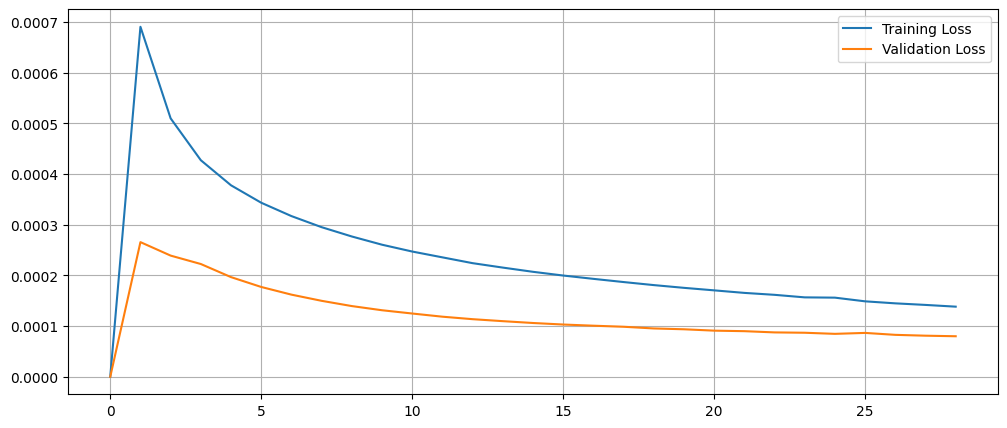

In [18]:
plt.figure(figsize=(12,5))
plt.plot(list(range(len(epoch_loss_values))), epoch_loss_values, label="Training Loss")
plt.plot(list(range(len(mae_val))), mae_val , label="Validation Loss")
plt.grid(True, "both", "both")
plt.legend()
plt.savefig(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/lossfunction.png')


In [19]:
CNN_model.load_state_dict(torch.load(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/checkpoint.pt'))
CNN_model.eval()

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (D): Dropout(p=0.2, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.2, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): BatchNorm3d(1

In [20]:
# running inference on only one test subject
test_gad = sorted(glob('/localscratch/tmp/passing_dataset/sub-P*/sub-P*_acq-gad_rescaled_T1w.nii.gz'))[0:2]
test_nongad = sorted(glob('/localscratch/tmp/passing_dataset/sub-P*/sub-P*_acq-nongad_normalized_fcm.nii.gz'))[0:2]
test_dict = [{"image": gad_name, "label": nongad_name} for gad_name, nongad_name in zip(test_gad,test_nongad)] #creates list of dictionaries, with gad and nongad images labelled


inference_transforms = Compose( #loading full image
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"])])
        

infer_ds = Dataset(data=test_dict, transform=inference_transforms) 
infer_loader = DataLoader(infer_ds, batch_size=1, shuffle=True) #using pytorch's dataloader



In [21]:
degad_imgs = []
gad_infer_imgs = []
nongad_infer_imgs = []
for infer_imgs in infer_loader:
    gad_infer_imgs.append(infer_imgs["image"])
    nongad_infer_imgs.append(infer_imgs["label"])
    output_degad_img = sliding_window_inference(inputs = infer_imgs["image"].to('cpu'), roi_size = (16,16,16), sw_batch_size= 5, predictor = CNN_model.to('cpu'), overlap = 0.25, mode = "gaussian", sw_device= 'cpu', device = 'cpu', progress = True )
    degad_imgs.append(output_degad_img)

100%|██████████| 2007/2007 [01:54<00:00, 17.53it/s]


In [22]:
for i in range(len(degad_imgs)): #looping thru number of output files
    degad_img =degad_imgs[i][0][0] # reshaping to exclude batch and channels (only one channel)
    gad_image= nibabel.load(test_dict[i]["image"]) # getting original gad image back to compare to 
    gad_image_file = test_dict[i]["image"]
    print(gad_image_file)
    sub = os.path.basename(gad_image_file).split("_")[0]
    degad_name = f'{sub}_acq-degad_T1w.nii.gz'
    degad_file = nibabel.Nifti1Image(degad_img.detach().numpy()*100, affine= gad_image.affine,header= gad_image.header) # with same header as inference gad 
    output_dir = f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/test'
    os.makedirs(f'{output_dir}/bids/{sub}/ses-pre/anat', exist_ok=True)# save in bids format
    output_path = f'{output_dir}/bids/{sub}/ses-pre/anat/{degad_name}'
    nibabel.save(degad_file,output_path) 

/localscratch/tmp/passing_dataset/sub-P002/sub-P002_acq-gad_rescaled_T1w.nii.gz
/localscratch/tmp/passing_dataset/sub-P003/sub-P003_acq-gad_rescaled_T1w.nii.gz


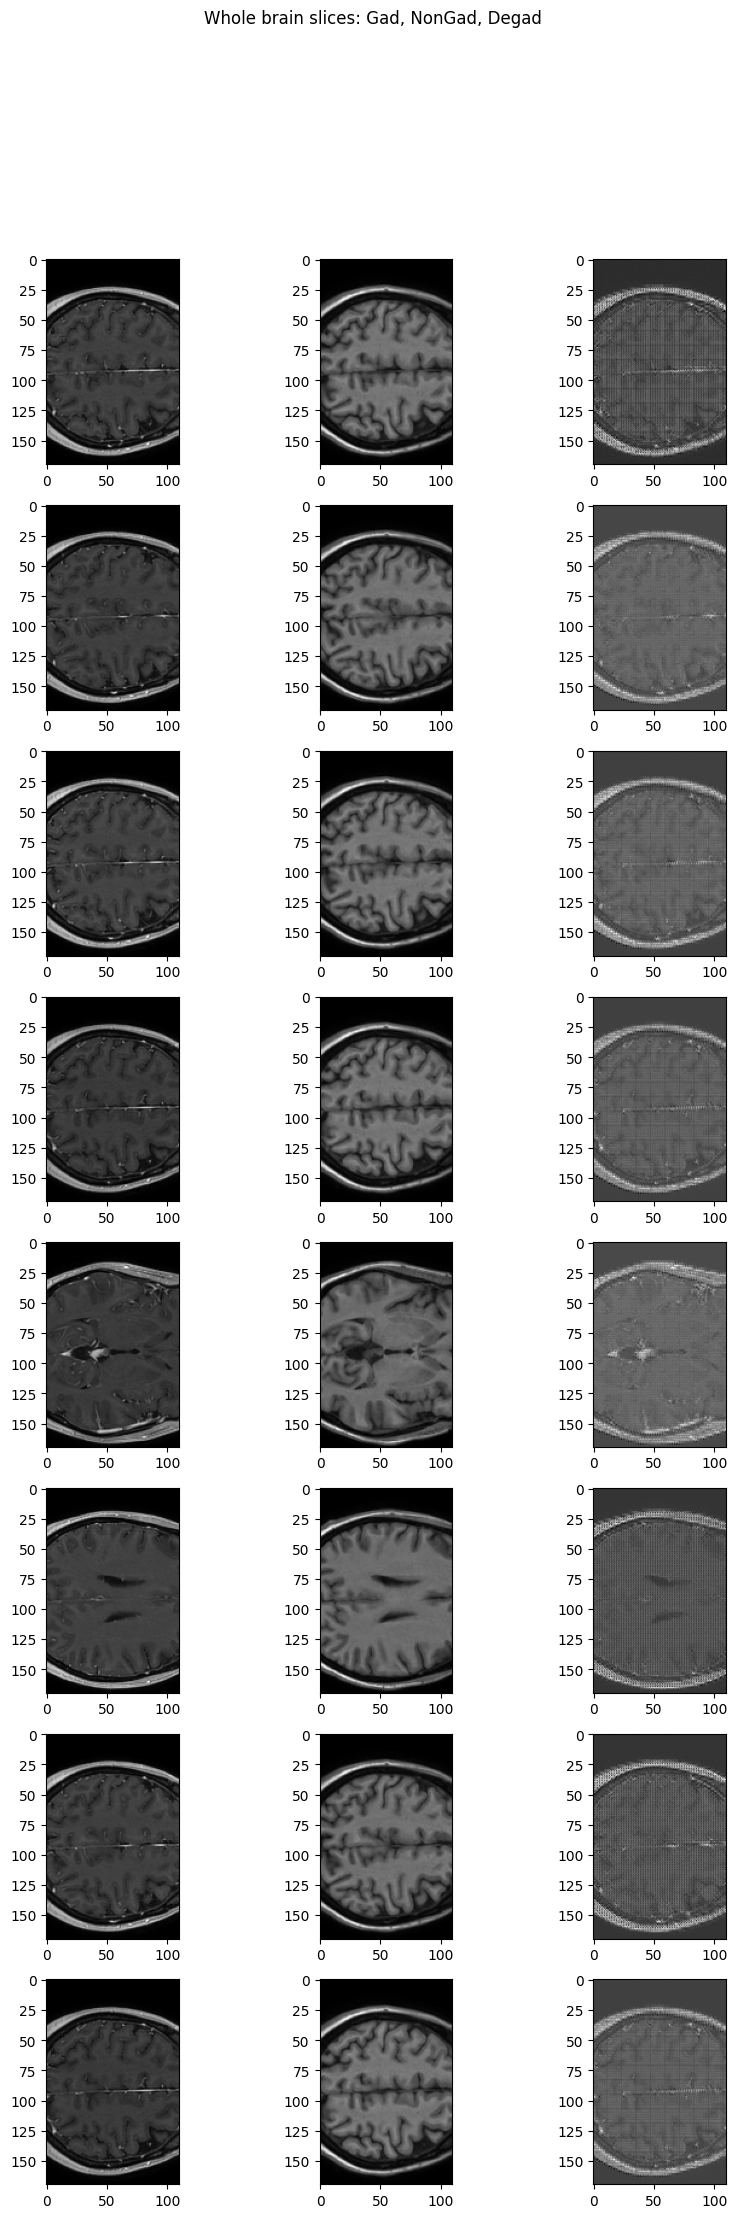

In [25]:
import random
## generating random whole brain slices
fig, axes = plt.subplots(8, 3,figsize=(10,25))
plt.suptitle('Whole brain slices: Gad, NonGad, Degad')

for i in range (1,25,3):
    plt.subplot(8, 3, i)
    x = random.randint(80, 130)
    plt.imshow(gad_infer_imgs[0][0, 0,40:210 ,40:150, x].cpu().data.numpy(), cmap ="gray")
    
    plt.subplot(8, 3, i+1)
    plt.imshow(nongad_infer_imgs[0][0, 0, 40:210 , 40:150, x].cpu().data.numpy(), "gray")
    
    plt.subplot(8, 3, i+2)
    plt.imshow(degad_imgs[0][0, 0, 40:210,40:150, x].cpu().data.numpy(), "gray")

plt.savefig(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/test/figure_whole_brain.png')

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


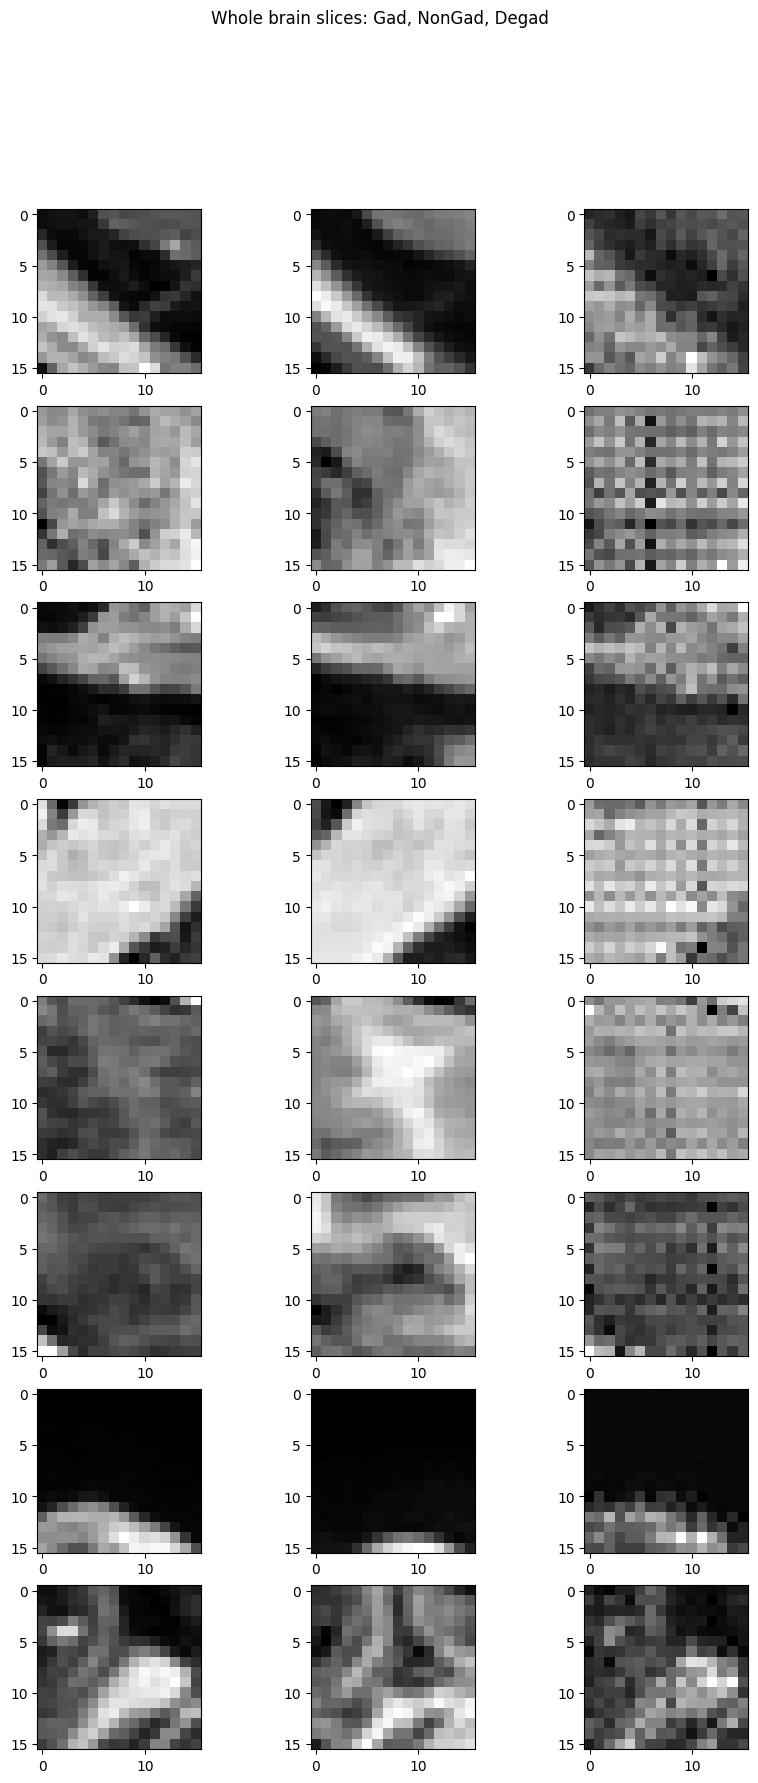

In [26]:
#generating random 32x32 slices
fig, axes = plt.subplots(8, 4,figsize=(10,20))
plt.suptitle('Whole brain slices: Gad, NonGad, Degad')

for i in range (1,25,3):
    
    x = random.randint(40, 190)
    y = random.randint(40, 190)
    z = random.randint(40, 190)
    plt.subplot(8, 3, i)
    plt.imshow(gad_infer_imgs[0][0, 0, x:x+16,y:y+16 ,50].cpu().data.numpy(), cmap ="gray")
    plt.subplot(8, 3, i+1)
    plt.imshow(nongad_infer_imgs[0][0, 0, x:x+16,y:y+16,50].cpu().data.numpy(), "gray")
    plt.subplot(8, 3, i+2)
    plt.imshow(degad_imgs[0][0, 0, x:x+16,y:y+16,50].cpu().data.numpy(), "gray")
   

plt.savefig(f'/home/fogunsan/scratch/degad/derivatives/UNET/{date}/test/figure_16_patches.png')  